In [3]:
!pip install pandas numpy joblib tqdm matplotlib


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/111.9 kB ? eta -:--:--
     --- ------------------------------------ 10.2/111.9 kB ? eta -:--:--
     -------------------------------------- 111.9/111.9 kB 1.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.4/8.1 MB 8.5 MB/s eta 0:00:01
   ---- ----------------------------------- 0.8/8.1 MB 8.8 MB/s eta 0:00:01
   ------ --------------------------------- 1.3/8.1 MB 9.3 MB/s eta 0:00:01
   -------- ------------------------------- 1.7/8.1 MB 10.0 MB/s eta 0:00:01
   ---------- ----------------------------- 2.2/8.1 MB 9.4 MB/s eta 0:00:01
   ------------- -------------------------- 2.7/8.1 MB 9.7 MB/s eta 0:00:01
   --------------- ------------------------ 3.2/8.1 MB 9.8 MB/s eta 0:00:01
   ------------------ --------------------- 3.7/8.1 MB 10.2 MB/s eta 0:00:01
   -------------------- ------


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Dataset loaded. Shape: (2000, 15)


,Train_ID,Train_Type,Current_Position,Delay_Min,Buffer_Min,Track_Availability,Stopping_Pattern,Section_Type,Speed_Limit,Decision,Hold_Station,Hold_Time,Reroute_Path,Additional_Time,Reason
0,T0001,Express,Section_19,58,32,Occupied,All Stops,Double-line,110,Reroute Train T0001,NaN,NaN,Section_16 → Section_50 → Station_20,8.0,Accident
1,T0002,Passenger,Section_12,74,44,Free,All Stops,Single-line,90,Hold Train T0002,Station_44,9.0,NaN,NaN,NaN
2,T0003,Passenger,Station_49,29,2,Free,All Stops,Double-line,80,Hold Train T0003,Station_9,11.0,NaN,NaN,NaN
3,T0004,Freight,Section_34,28,37,Occupied,Skip,Single-line,80,Reroute Train T0004,NaN,NaN,Station_14 → Station_20 → Station_15,40.0,Weather
4,T0005,Express,Section_1,117,52,Free,Skip,Single-line,110,Reroute Train T0005,NaN,NaN,Station_7 → Section_42 → Section_24,40.0,Congestion


Training Episodes: 100%|██████████| 2000/2000 [07:38<00:00,  4.37it/s]


Q-table saved as q_table_scheduler.joblib


,Train_ID,Train_Type,Current_Position,Delay_Min,Buffer_Min,Track_Availability,Stopping_Pattern,Section_Type,Speed_Limit,Decision,Hold_Station,Hold_Time,Reroute_Path,Additional_Time,Reason,Policy_Decision
0,T0001,Express,Section_19,58,32,Occupied,All Stops,Double-line,110,Reroute Train T0001,NaN,NaN,Section_16 → Section_50 → Station_20,8.0,Accident,Allow Train T0001 to go first
1,T0002,Passenger,Section_12,74,44,Free,All Stops,Single-line,90,Hold Train T0002,Station_44,9.0,NaN,NaN,NaN,Allow Train T0002 to go first
2,T0003,Passenger,Station_49,29,2,Free,All Stops,Double-line,80,Hold Train T0003,Station_9,11.0,NaN,NaN,NaN,Allow Train T0003 to go first
3,T0004,Freight,Section_34,28,37,Occupied,Skip,Single-line,80,Reroute Train T0004,NaN,NaN,Station_14 → Station_20 → Station_15,40.0,Weather,Allow Train T0004 to go first
4,T0005,Express,Section_1,117,52,Free,Skip,Single-line,110,Reroute Train T0005,NaN,NaN,Station_7 → Section_42 → Section_24,40.0,Congestion,Allow Train T0005 to go first


Policy-enhanced dataset saved as train_scheduling_with_policy.csv


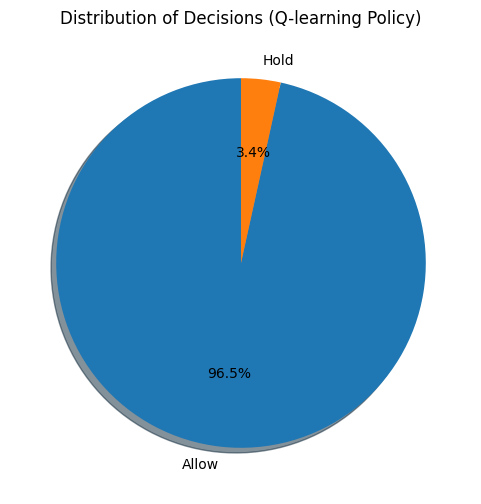

In [4]:
# ==========================
# 🚆 Q-learning Train Scheduler (All-in-One)
# ==========================

# Imports
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt

# Path to dataset
CSV_PATH = "train_scheduling_dataset_updated.csv"

# Load dataset
df = pd.read_csv(CSV_PATH)
print("Dataset loaded. Shape:", df.shape)
display(df.head())

# Actions for scheduler
actions = ["Allow", "Hold", "Reroute"]

# Function to create a simplified state representation
def get_state(row):
    return (
        row["Train_Type"],
        row["Track_Availability"],
        row["Section_Type"],
        int(row["Delay_Min"] > 10),   # High delay or not
        int(row["Buffer_Min"] < 10)   # Low buffer or not
    )

# Reward function for environment
def simulate_env(state, action):
    train_type, track, section, high_delay, low_buffer = state
    
    reward = -1  # default penalty
    if action == "Allow":
        if high_delay or low_buffer:
            reward = 10
        else:
            reward = 2
    elif action == "Hold":
        if track == "Occupied":
            reward = 8
        else:
            reward = -5
    elif action == "Reroute":
        if track == "Occupied":
            reward = 6
        else:
            reward = -3
    return reward

# Q-table (pickle-safe)
Q = {}
def get_q_values(state):
    if state not in Q:
        Q[state] = np.zeros(len(actions))
    return Q[state]

# Hyperparameters
alpha = 0.1
gamma = 0.9
epsilon = 0.2
episodes = 2000

# Training loop
for ep in tqdm(range(episodes), desc="Training Episodes"):
    for i, row in df.iterrows():
        state = get_state(row)
        q_values = get_q_values(state)
        
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action_idx = random.randint(0, len(actions)-1)
        else:
            action_idx = np.argmax(q_values)
        
        action = actions[action_idx]
        reward = simulate_env(state, action)
        
        # Next state
        next_state = state
        next_q_values = get_q_values(next_state)
        best_next_action = np.argmax(next_q_values)
        
        # Q-update
        q_values[action_idx] += alpha * (reward + gamma * next_q_values[best_next_action] - q_values[action_idx])

# Save trained Q-table
joblib.dump(Q, "q_table_scheduler.joblib")
print("Q-table saved as q_table_scheduler.joblib")

# Evaluate policy and add to dataset
policy_decisions = []
for i, row in df.iterrows():
    state = get_state(row)
    best_action = actions[np.argmax(get_q_values(state))]
    
    if best_action == "Allow":
        decision = f"Allow Train {row['Train_ID']} to go first"
    elif best_action == "Hold":
        decision = f"Hold Train {row['Train_ID']} at nearest station"
    else:
        decision = f"Reroute Train {row['Train_ID']} via alternate path"
    
    policy_decisions.append(decision)

df["Policy_Decision"] = policy_decisions
display(df.head())

# Save dataset with policy decisions
df.to_csv("train_scheduling_with_policy.csv", index=False)
print("Policy-enhanced dataset saved as train_scheduling_with_policy.csv")

# Visualize policy distribution
plt.figure(figsize=(6,6))
df["Policy_Decision"].apply(lambda x: x.split()[0]).value_counts().plot(
    kind="pie", autopct="%1.1f%%", startangle=90, shadow=True
)
plt.title("Distribution of Decisions (Q-learning Policy)")
plt.ylabel("")
plt.show()


In [4]:
# ==========================
# 🚆 Evaluate Trained Q-learning Scheduler
# ==========================

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Path to dataset
CSV_PATH = "train_scheduling_dataset_updated.csv"

# Load dataset
df = pd.read_csv(CSV_PATH)
print("Dataset loaded. Shape:", df.shape)

# Actions for scheduler
actions = ["Allow", "Hold", "Reroute"]

# Load trained Q-table
Q = joblib.load("q_table_scheduler.joblib")
print("Trained Q-table loaded.")

# Function to create state representation (same as training)
def get_state(row):
    return (
        row["Train_Type"],
        row["Track_Availability"],
        row["Section_Type"],
        int(row["Delay_Min"] > 10),   # High delay or not
        int(row["Buffer_Min"] < 10)   # Low buffer or not
    )

# Function to get best action from Q-table
def get_best_action(state):
    if state in Q:
        return actions[np.argmax(Q[state])]
    else:
        # If state unseen, choose random
        return np.random.choice(actions)

# Split dataset into train/test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Evaluate Q-table on test set
y_true = []   # For "ground truth" policy (we can use reward function)
y_pred = []

# Define "ground truth" as the action that gives max reward (simulate_env)
def simulate_env(state, action):
    train_type, track, section, high_delay, low_buffer = state
    reward = -1
    if action == "Allow":
        if high_delay or low_buffer:
            reward = 10
        else:
            reward = 2
    elif action == "Hold":
        if track == "Occupied":
            reward = 8
        else:
            reward = -5
    elif action == "Reroute":
        if track == "Occupied":
            reward = 6
        else:
            reward = -3
    return reward

for i, row in test_df.iterrows():
    state = get_state(row)
    
    # Predicted action from Q-table
    pred_action = get_best_action(state)
    y_pred.append(pred_action)
    
    # Ground truth: action with highest reward
    rewards = [simulate_env(state, a) for a in actions]
    best_reward_action = actions[np.argmax(rewards)]
    y_true.append(best_reward_action)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Q-learning policy accuracy on test set: {accuracy*100:.2f}%")


Dataset loaded. Shape: (2000, 15)
Trained Q-table loaded.
Q-learning policy accuracy on test set: 100.00%


In [1]:
import joblib
import numpy as np

# Scheduler actions
actions = ["Allow", "Hold", "Reroute"]
Q = joblib.load("q_table_scheduler.joblib")  # Load your Q-table

def get_state_from_input(train_type, track_avail, section_type, delay, buffer):
    return (
        train_type,
        track_avail,
        section_type,
        int(delay > 10),     # High delay?
        int(buffer < 10)     # Low buffer?
    )

def get_best_action(state):
    if state in Q:
        return actions[np.argmax(Q[state])]
    else:
        return np.random.choice(actions)

while True:
    print("\n--- Enter Train Details ---")
    train_id = input("Train ID: ").strip()
    train_type = input("Train Type (Passenger/Express/Freight): ").strip()
    current_pos = input("Current Position (Station/Section): ").strip()
    delay = int(input("Delay (min): "))
    buffer = int(input("Scheduled Buffer (min): "))
    track_avail = input("Track Availability Ahead (Free/Occupied): ").strip()
    stopping_pattern = input("Stopping Pattern (All Stops/Skip): ").strip()
    section_type = input("Section Type (Double-line/Single-line): ").strip()
    speed_limit = int(input("Speed Limit Next Section (km/h): "))

    # Prepare state
    state = get_state_from_input(train_type, track_avail, section_type, delay, buffer)
    decision = get_best_action(state)

    print("\n--- Scheduling Decision ---")
    if decision == "Allow":
        print(f"Decision: Allow Train {train_id} to go first")
    elif decision == "Hold":
        print(f"Decision: Hold Train {train_id}")
        # Optionally prompt for hold station/time
    elif decision == "Reroute":
        print(f"Decision: Reroute Train {train_id}")
        # Optionally prompt for reroute path/reason

    # To continue or exit
    cont = input("\nTry another? (y/n): ").lower()
    if cont != 'y':
        break



--- Enter Train Details ---

--- Scheduling Decision ---
Decision: Allow Train T0003 to go first


In [ ]:
"""import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv("train_scheduling_dataset_updated.csv")

# Accept Train_ID as input from user
train_id = input("Enter the Train ID: ").strip()

# Filter records of the train
train_data = df[df['Train_ID'] == train_id]

if train_data.empty:
    print(f"No records found for Train ID {train_id}")
else:
    train_data = train_data.reset_index(drop=True)
    # Plot numeric features over record index
    plt.figure(figsize=(12,6))
    plt.plot(train_data.index, train_data['Delay_Min'], marker='o', label='Delay (min)')
    plt.plot(train_data.index, train_data['Buffer_Min'], marker='o', label='Buffer (min)')
    plt.plot(train_data.index, train_data['Speed_Limit'], marker='o', label='Speed Limit (km/h)')
    plt.xticks(train_data.index)
    plt.xlabel("Record Number")
    plt.ylabel("Value")
    plt.title(f"Performance Trends for Train {train_id}")
    plt.legend()
    plt.grid(True)
    plt.show()
    # Bar chart of Stopping Pattern frequency
    stopping_counts = train_data['Stopping_Pattern'].value_counts()
    plt.figure()
    stopping_counts.plot(kind='bar', title=f'Stopping Pattern Frequency for Train {train_id}')
    plt.xlabel("Stopping Pattern")
    plt.ylabel("Count")
    plt.show()
    # Print scheduling decision and other info
    print(f"\nScheduling Decisions for Train {train_id}:")
    print(train_data[['Decision', 'Hold_Station', 'Hold_Time', 'Reroute_Path', 'Additional_Time', 'Reason']])"""


No records found for Train ID T2020


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("train_scheduling_dataset_updated.csv")

# Input two Train_IDs from user
train_id1 = input("Enter first Train ID: ").strip()
train_id2 = input("Enter second Train ID: ").strip()

# Filter data for each train
train_data1 = df[df['Train_ID'] == train_id1]
train_data2 = df[df['Train_ID'] == train_id2]

if train_data1.empty:
    print(f"No records found for Train ID {train_id1}")
if train_data2.empty:
    print(f"No records found for Train ID {train_id2}")

if train_data1.empty or train_data2.empty:
    print("Comparison aborted due to missing data.")
else:
    # Reset indices for plotting consistency
    train_data1 = train_data1.reset_index(drop=True)
    train_data2 = train_data2.reset_index(drop=True)

    plt.figure(figsize=(14,7))

    # Plot Delay_Min for both trains
    plt.plot(train_data1.index, train_data1['Delay_Min'], marker='o', label=f'Delay {train_id1}')
    plt.plot(train_data2.index, train_data2['Delay_Min'], marker='o', label=f'Delay {train_id2}')
    
    # Plot Buffer_Min for both trains
    plt.plot(train_data1.index, train_data1['Buffer_Min'], marker='x', label=f'Buffer {train_id1}', linestyle='--')
    plt.plot(train_data2.index, train_data2['Buffer_Min'], marker='x', label=f'Buffer {train_id2}', linestyle='--')
    
    plt.xlabel("Record Number")
    plt.ylabel("Minutes")
    plt.title(f"Delay and Buffer Comparison: Train {train_id1} vs Train {train_id2}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Bar chart of Stopping Pattern frequency for both trains side-by-side
    stopping_counts1 = train_data1['Stopping_Pattern'].value_counts()
    stopping_counts2 = train_data2['Stopping_Pattern'].value_counts()

    # Combine patterns
    combined_patterns = list(set(stopping_counts1.index) | set(stopping_counts2.index))
    counts1 = [stopping_counts1.get(pat, 0) for pat in combined_patterns]
    counts2 = [stopping_counts2.get(pat, 0) for pat in combined_patterns]

    x = range(len(combined_patterns))
    width = 0.35

    plt.figure(figsize=(10,6))
    plt.bar(x, counts1, width=width, label=f'Train {train_id1}')
    plt.bar([p + width for p in x], counts2, width=width, label=f'Train {train_id2}')
    plt.xticks([p + width/2 for p in x], combined_patterns)
    plt.xlabel("Stopping Pattern")
    plt.ylabel("Count")
    plt.title(f"Stopping Pattern Frequency Comparison: Train {train_id1} vs Train {train_id2}")
    plt.legend()
    plt.show()

    # Print scheduling decisions for both trains
    print(f"\nScheduling Decisions for Train {train_id1}:")
    print(train_data1[['Decision', 'Hold_Station', 'Hold_Time', 'Reroute_Path', 'Additional_Time', 'Reason']])
    print(f"\nScheduling Decisions for Train {train_id2}:")
    print(train_data2[['Decision', 'Hold_Station', 'Hold_Time', 'Reroute_Path', 'Additional_Time', 'Reason']])


ModuleNotFoundError: No module named 'matplotlib'

In [3]:
import pandas as pd
import joblib

# ==============================
# 1. Load Dataset
# ==============================
df = pd.read_csv("train_scheduling_dataset_updated.csv")

# Preview data
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

# ==============================
# 2. Load Q-table
# ==============================
q_table = joblib.load("q_table_scheduler.joblib")

print("\n✅ Q-table loaded. Type:", type(q_table))

if isinstance(q_table, dict):
    print("Number of states in Q-table:", len(q_table))
else:
    try:
        print("Q-table shape:", q_table.shape)
    except AttributeError:
        print("Q-table details:", q_table)

# ==============================
# 3. KPI Calculation Function
# ==============================
def calculate_kpis(train_id):
    train_data = df[df['Train_ID'] == train_id]   # <-- FIXED column name

    if train_data.empty:
        return f"⚠️ No data found for Train_ID {train_id}"

    # --- Punctuality ---
    if 'Delay_Min' in df.columns:
        punctual_trains = train_data[train_data['Delay_Min'] <= 0]
        punctuality = len(punctual_trains) / len(train_data) * 100
    else:
        punctuality = None  # Not available

    # --- Average Delay ---
    avg_delay = train_data['Delay_Min'].mean() if 'Delay_Min' in df.columns else None

    # --- Throughput ---
    throughput = len(train_data)  # Number of rows for this train

    # --- Utilization ---
    utilization = throughput / df['Train_ID'].nunique() * 100

    return {
        "Train ID": train_id,
        "Punctuality (%)": round(punctuality, 2) if punctuality is not None else "N/A",
        "Average Delay (min)": round(avg_delay, 2) if avg_delay is not None else "N/A",
        "Throughput (#records)": throughput,
        "Utilization (%)": round(utilization, 2)
    }

# ==============================
# 4. Example Usage
# ==============================
train_id = "T0005"  # Example train ID from your dataset
kpis = calculate_kpis(train_id)

print("\n📊 KPI Results:")
print(kpis)


Dataset shape: (2000, 15)
Columns: ['Train_ID', 'Train_Type', 'Current_Position', 'Delay_Min', 'Buffer_Min', 'Track_Availability', 'Stopping_Pattern', 'Section_Type', 'Speed_Limit', 'Decision', 'Hold_Station', 'Hold_Time', 'Reroute_Path', 'Additional_Time', 'Reason']

✅ Q-table loaded. Type: <class 'dict'>
Number of states in Q-table: 44

📊 KPI Results:
{'Train ID': 'T0005', 'Punctuality (%)': 0.0, 'Average Delay (min)': 117.0, 'Throughput (#records)': 1, 'Utilization (%)': 0.05}
